# Custom Model Compilation and Inference using Onnx runtime 

In this example notebook, we describe how to take a pre-trained classification model and compile it using ***Onnx runtime*** to generate deployable artifacts that can be deployed on the target using the ***Onnx*** interface. 
 
 - Pre-trained model: `resnet18v2` model trained on ***ImageNet*** dataset using ***Onnx***  
 
In particular, we will show how to
- compile the model (during heterogenous model compilation, layers that are supported will be offloaded to the`TI-DSP` and artifacts needed for inference are generated)
- use the generated artifacts for inference
- perform input preprocessing and output postprocessing
- enable debug logs
- use deny-layer compilation option to isolate possible problematic layers and create additional model subgraphs
- use the generated subgraphs artifacts for inference
- perform input preprocessing and output postprocessing
    
## Onnx Runtime based work flow

The diagram below describes the steps for Onnx Runtime based work flow. 

Note:
 - The user needs to compile models(sub-graph creation and quantization) on a PC to generate model artifacts.
 - The generated artifacts can then be used to run inference on the target.

<img src=docs/images/onnx_work_flow_2.png width="400">

In [1]:
import os
import sys
import tqdm
import cv2
import numpy as np
import onnxruntime as rt
import onnx
import shutil
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import Markdown as md
# import functions from local scripts
sys.path.insert(0, os.path.abspath("."))
from my_scripts.utils import imagenet_class_to_name, download_model
from my_scripts.utils import loggerWriter
from my_scripts.utils import get_svg_path

## Set the model to evaluate and images to use for fixed-point calibration
We will set the model file to be used. If this is recognized as a TI model, we will download it from our zoo. For custom models, users will need to ensure that file is present on the local filesystem

A set of calibration images are used to find an appropriate quantization so the floating point model can run on a fixed-point accelerator. For a custom-trained model, it is best to use representative data from the data set.


In [2]:
output_dir = 'custom-artifacts/onnx/'
onnx_model_path = '/home/giovanna/Documentos/IC/NPU_development/to_aquila/compiled_onnxrt_AM69A/model/model_best.onnx'
#Recognized TI models will be downloaded from our Model Zoo if not already present in the filesystem
download_model(onnx_model_path)
# Use ONNX to infer shapes of tensor dimensions within the model so they are known prior to compilation. 
onnx.shape_inference.infer_shapes_path(onnx_model_path, onnx_model_path)

# For highly application-specific models, it is recommended to use representative data from your dataset
# calibration images are used for post training quantization 
calib_images = [
'/home/giovanna/Documentos/Research - Github/Only_Bike_Dataset/DSv1/images/final_frames/image_0049.jpg',
'/home/giovanna/Documentos/Research - Github/Only_Bike_Dataset/DSv1/images/final_frames/image_0088.jpg',
'/home/giovanna/Documentos/Research - Github/Only_Bike_Dataset/DSv1/images/final_frames/image_0100.jpg',
'/home/giovanna/Documentos/Research - Github/Only_Bike_Dataset/DSv1/images/final_frames/image_0119.jpg',
]

In [3]:
import onnx
model = onnx.load(onnx_model_path)
onnx.checker.check_model(model)
print("Modelo ONNX está OK!")


Modelo ONNX está OK!


## Define utility function to preprocess input images for our model
Below, we define a utility function to preprocess images for `resnet18v2`. This function takes a path as input, loads the image and preprocesses it for generic ***Onnx*** inference. The steps are as follows: 

 1. load image
 2. convert BGR image to RGB
 3. scale image so that the short edge is 256 pixels
 4. center-crop image to 224x224 pixels
 5. apply per-channel pixel scaling and mean subtraction


- Note: If you are using a custom model or a model that was trained using a different framework, please remember to define your own utility function.

In [4]:
import torch 
def preprocess(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # redimensiona direto pra shape do modelo
    img = cv2.resize(img, (512, 512))

    # normaliza
    #img = img.astype('float32') / 255.0

    # muda de HWC pra CHW
    img = np.expand_dims(img,axis=0)
    img = np.transpose(img, (0, 3, 1, 2))
    # adiciona batch dimension
    #img = np.expand_dims(img, axis=0)

    #return img
    return img


## Compile the model
In this step, we create Onnx runtime with `tidl_model_import_onnx` library to generate artifacts that offload supported portion of the DL model to the TI DSP.
 - `sess` is created with the options below to calibrate the model for 8-bit fixed point inference
   
    * **artifacts_folder** - folder where all the compilation artifacts needed for inference are stored 
    * **tidl_tools_path** - os.getenv('TIDL_TOOLS_PATH'), path to `TIDL` compilation tools 
    * **tensor_bits** - 8 or 16, is the number of bits to be used for quantization 
    * **advanced_options:calibration_frames**  - number of images to be used for calibration
     
    ``` 
    compile_options = {
        'tidl_tools_path' : os.environ['TIDL_TOOLS_PATH'],
        'artifacts_folder' : output_dir,
        'tensor_bits' : 16,
        'accuracy_level' : 0,
        'advanced_options:calibration_frames' : len(calib_images), 
        'advanced_options:calibration_iterations' : 3 # used if accuracy_level = 1
    }
    ``` 
    
- Note: The path to `TIDL` compilation tools and `aarch64` `GCC` compiler is required for model compilation, both of which are accessed by this notebook using predefined environment variables `TIDL_TOOLS_PATH` and `ARM64_GCC_PATH`. The example usage of both the variables is demonstrated in the cell below. 
- `accuracy_level` is set to 0 in this example. For better accuracy, set `accuracy_level = 1`. This option results in more time for compilation but better inference accuracy. 
Compilation status log for accuracy_level = 1 is currently not implemented in this notebook. This will be added in future versions. 
- Please refer to TIDL user guide and the edgeai-tidl-tools repository documentation for further compilation options.

### Layers debug (optional - In case of debugging)
debug_level 1 gives layer information and warnings/errors which could be useful during debug. User's can see logs from compilation inside a giving path to "loggerWriter" helper function.

Another technique is to use deny_list to exclude layers from running on TIDL and create additional subgraphs, in order to isolate issues.

### Compilation knobs  (optional - In case of debugging accuracy)
if a model accuracy at 8bits is not good, user's can try compiling same model at 16 bits with accuracy level of 1. This will reduce the performance, but it will give users a good accuracy bar.
As a second step, user can try to increase 8 bits accuracy by increasing the number of calibration frames and iterations, in order to get closer to 16 bits + accuracy level of 1 results.

In [5]:
import os

os.environ['TIDL_TOOLS_PATH'] = "/home/giovanna/Documentos/IC/NPU_development/edgeai-tidl-tools/tools/AM69A/tidl_tools"


In [6]:
from my_scripts.utils import loggerWriter

log_dir = Path("logs").mkdir(parents=True, exist_ok=True)

# debug level -- use 1 or 2 for increased verbosity in the error messages. See log files to view all printed messages
debug_level=1 

#compilation options - knobs to tweak 
num_bits =8
accuracy =1

# stdout and stderr saved to a *.log file.  
with loggerWriter("logs/custon-model-onnx"):
    
    # model compilation options
    compile_options = {
        'tidl_tools_path' : os.environ['TIDL_TOOLS_PATH'],
        'artifacts_folder' : output_dir,
        'tensor_bits' : num_bits,
        'accuracy_level' : accuracy,
        'debug_level' : debug_level,
        'advanced_options:calibration_frames' : len(calib_images), 
        'advanced_options:calibration_iterations' : 3, # used if accuracy_level = 1
        'advanced_options:add_data_convert_ops' : 1,
        #'deny_list' : "MaxPool" #Comma separated string of operator types as defined by ONNX runtime, ex "MaxPool, Concat"
    }


In [7]:
import os
os.makedirs("logs", exist_ok=True)
os.environ['TIDL_LOG_LEVEL'] = '3'
os.environ['TIDL_RT_PERFSTATS'] = '1'
#os.environ['LD_LIBRARY_PATH'] = "/home/giovanna/Documentos/IC/NPU_development/edgeai-tidl-tools/tools/AM69A/tidl_tools"
#os.environ["LD_LIBRARY_PATH"] = "/usr/lib/x86_64-linux-gnu"



<div class="alert alert-block alert-info">
<b>Note:</b> Please note 'deny_list' is used in above cell as an example and it can be deleted as "MaxPool" is a supported layer
</div>

In [8]:
# create the output dir if not present
# clear the directory
os.makedirs(output_dir, exist_ok=True)
for root, dirs, files in os.walk(output_dir, topdown=False):
    [os.remove(os.path.join(root, f)) for f in files]
    [os.rmdir(os.path.join(root, d)) for d in dirs]

In [9]:
# Run the compilation itself
# Setup onnxruntime, targeting the TIDL Compilation Provider, which will handle compilation itself
so = rt.SessionOptions()
EP_list = ['TIDLCompilationProvider','CPUExecutionProvider']
# Create the model's InferenceSession targeting the TIDL Compilation Provider, and pass all compile options to this provider
# When this call runs, compilation will begin but not complete because it is waiting for calibration data
sess = rt.InferenceSession(
    onnx_model_path ,
    providers=EP_list, 
    provider_options=[compile_options, {}], 
    sess_options=so
)

input_details = sess.get_inputs()

# Preprocess calibration data and pass it to the runtime. 
# Once at least 'calibration_frames' number of images are passed in, calibration can proceed
# Model compilation can complete after all calibration data is received and processed
for num in tqdm.trange(len(calib_images)):
    output = list(sess.run(None, {input_details[0].name : preprocess(calib_images[num])}))[0]

100%|██████████████████████████████████████████████████| 4/4 [00:57<00:00, 14.39s/it]


### Subgraphs visualization  (optional - In case of debugging models and subgraphs)
TIDL processes 'subgraphs' of supported layers that can run on the acclerator. Several SVG files are provided to visualize the network as a graph.

Running below cell gives links to complete graph and TIDL subgraphs visualizations. This, along with "deny_list" feature, explained above, offer tools for potentially checking and isolating issues in the neural network model layers.

In [11]:
subgraph_link =get_svg_path(output_dir) 
for sg in subgraph_link:
    hl_text = os.path.join(*Path(sg).parts[4:])
    sg_rel = os.path.join('../', sg)
    display(md("[{}]({})".format(hl_text,sg_rel)))

## Use compiled model for inference
Then using ***Onnx*** with the ***`libtidl_onnxrt_EP`*** inference library we run the model and collect benchmark data.

We will use a TIDLExecutionProvider to run model inference, instead of the TIDLCompilationProvider, which was used for compiling the model. 

The TIDLExecutionProvider similarly accepts a dictionary of options, and the compile_options can be reused, although some options will not apply for inference.

EP Error /root/onnxruntime/onnxruntime/core/providers/tidl/tidl_execution_provider.cc:94 onnxruntime::TidlExecutionProvider::TidlExecutionProvider(const onnxruntime::TidlExecutionProviderInfo&) status == true was false. 
 when using ['TIDLExecutionProvider', 'CPUExecutionProvider']
Falling back to ['CPUExecutionProvider'] and retrying.


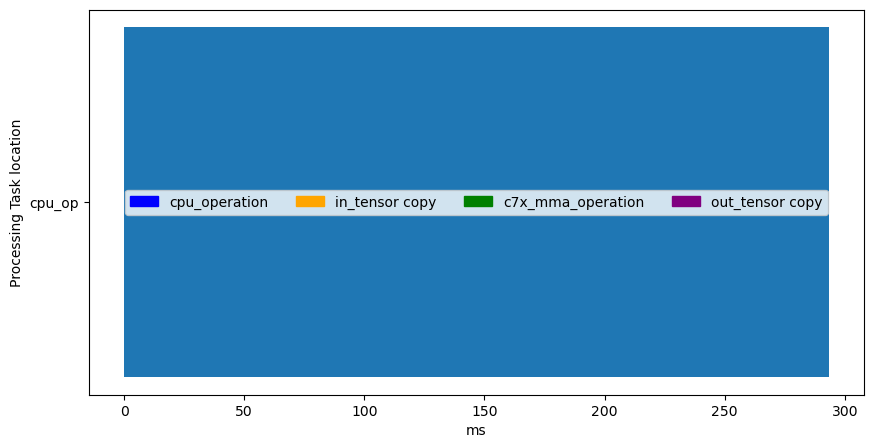

Statistics : 
 Inferences Per Second   :    3.41 fps
 Inference Time Per Image :  293.27 ms  
 DDR BW Per Image        :    0.00 MB


In [14]:
# select TIDLExecutionProvider for inference of supported layers
EP_list = ['TIDLExecutionProvider','CPUExecutionProvider']

# setup the InferenceSession for this model and pass similar options as compilation. 
sess = rt.InferenceSession(onnx_model_path ,providers=EP_list, provider_options=[compile_options, {}], sess_options=so)
#Running inference several times to get an stable performance output
for i in range(5):
    output = list(sess.run(None, {input_details[0].name : preprocess('/home/giovanna/Documentos/Research - Github/Only_Bike_Dataset/DSv1/images/final_frames/image_0049.jpg')}))

# for idx, cls in enumerate(output[0].squeeze().argsort()[-5:][::-1]):
#     print('[%d] %s' % (idx, '/'.join(imagenet_class_to_name(cls))))
    
from scripts.utils import plot_TI_performance_data, plot_TI_DDRBW_data, get_benchmark_output
# Pull TI performance measurements from the runtime
stats = sess.get_TI_benchmark_data()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
plot_TI_performance_data(stats, axis=ax)
plt.show()

# Process stats to get total time (tt), processing time(st), ddr read time (rb), and ddr write time (wb) for one model inference
tt, st, rb, wb = get_benchmark_output(stats)
print(f'Statistics : \n Inferences Per Second   : {1000.0/tt :7.2f} fps')
print(f' Inference Time Per Image : {tt :7.2f} ms  \n DDR BW Per Image        : {rb+ wb : 7.2f} MB')

## EVM's console logs (optional - in case of inference failure)

To copy console logs from EVM to TI EdgeAI Cloud user's workspace, go to: "Help -> Troubleshooting -> EVM console log", In TI's EdgeAI Cloud landing page.

Alternatevely, from workspace, open/run evm-console-log.ipynb